# Tutorial 4: Visualize results

In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_img import *
from datasets.data_manager_SMA import SMA

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from collections import defaultdict

from palettable.cartocolors.diverging import *
from palettable.scientific.diverging import *

### Load dataset

In [ ]:
# please load the target Visium data (from the uploaded)
adata_path = '/home/wzk/ST_code/NicheTrans/2024_NicheTrans_upload_data/2023_nbt_SMA/Processed_data_used/V11L12-109_A1'
rna_adata = sc.read_visium(path=adata_path, count_file='filtered_feature_bc_matrix.h5')

In [3]:
coordiantes = []
for i in range(rna_adata.shape[0]):
    coordiantes.append(str(rna_adata.obs['array_row'].values[i]) + '_' + str(rna_adata.obs['array_col'].values[i]) )
coordiantes = np.array(coordiantes)

rna_adata.obs['coordinates'] = coordiantes

### Load args

In [4]:
%run ./args/args_SMA.py
args = args

### Create dataloader

In [5]:
# create the dataloaders
dataset = SMA(path_img=args.path_img, rna_path=args.rna_path, msi_path=args.msi_path, n_top_genes=args.n_source, n_top_targets=args.n_target)
_, testloader = sma_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 12134 edges, 3120 cells.
3.8891 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 24190 edges, 3120 cells.
7.7532 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 11322 edges, 2918 cells.
3.8801 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 22578 edges, 2918 cells.
7.7375 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 10360 edges, 2675 cells.
3.8729 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20628 edges, 2675 cells.
7.7114 neighbors per cell on average.
=> SMA loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  Without filtering  6038 spots from     2 slides 
  test     |  Without filtering  2675 spots from     1 slides
  train    |  After filting  6005 spots from     2 

### Model initialization

In [6]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.msi_length
model = NicheTrans_img(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_*_SMA_last.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans_img(
    (base): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

### Model inference 

In [7]:
pd_dictionary, gt_dictionary = defaultdict(), defaultdict()
pd_value, gt_value = [], [] 

with torch.no_grad():
    for _, (imgs, source, target, source_neightbors, _, samples) in enumerate(testloader):

        source, target, source_neightbors = source.cuda(), target.cuda(), source_neightbors.cuda()
        imgs = imgs.cuda()

        outputs = model(imgs, source, source_neightbors)
        outputs = torch.clip(outputs, min=0)

        pd_value.append(outputs)
        gt_value.append(target)

        for i, sample in enumerate(samples):
            file_name, coordiantes = sample.split('/')

            pd_dictionary[coordiantes] = outputs[i].cpu().detach().numpy()
            gt_dictionary[coordiantes] = target[i].cpu().detach().numpy()

df_pd = pd.DataFrame.from_dict(pd_dictionary, orient='index', columns=['pd_' + str(i) for i in dataset.target_panel])
df_gt = pd.DataFrame.from_dict(gt_dictionary, orient='index', columns=['gt_' + str(i) for i in dataset.target_panel])

### Model evaluation

In [ ]:
from utils.evaluation import evaluator
pearson_sample_list, spearman_sample_list, _ = evaluator(df_pd.values, df_gt.values)

print(pearson_sample_list.mean())
print(spearman_sample_list.mean())

0.4159652476618717
0.499202671716816


### Save the predictions to adata

In [9]:
rna_adata.obs = rna_adata.obs.reset_index().merge(df_gt, left_on='coordinates', right_index=True, how='left').set_index('index')
rna_adata.obs = rna_adata.obs.reset_index().merge(df_pd, left_on='coordinates', right_index=True, how='left').set_index('index')

rna_adata = rna_adata[~np.isnan(rna_adata.obs['gt_390.16864'].values)] 

### Visualization

<Axes: title={'center': 'Prediction 428.14054'}, xlabel='spatial1', ylabel='spatial2'>

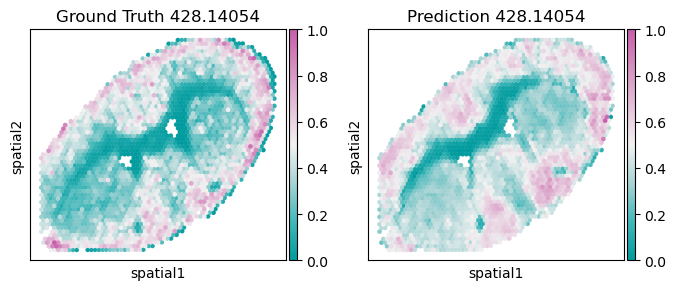

In [10]:
index = 9
name = dataset.target_panel[index]

key_pd, key_gt = 'pd_' + name, 'gt_' + name

temp_array_gt = rna_adata.obs[key_gt].values.copy()
temp_array_pd = rna_adata.obs[key_pd].values.copy()

temp_array_pd = np.exp(temp_array_pd) -1
temp_array_gt =  np.exp(temp_array_gt) -1


# min_value = np.nanmin(temp_array_pd)
# filter out the abnormal spots
target_value = np.nanmean(temp_array_gt) - 8 * np.nanstd(temp_array_gt) 
temp_mask = temp_array_gt < target_value
temp_array_gt[temp_mask] = None

key_norm = 'norm_' + name
rna_adata.obs[key_norm] = (temp_array_gt - np.nanmin(temp_array_gt)) / (np.nanmax(temp_array_gt) - np.nanmin(temp_array_gt))

pd_norm_name = 'pd_norm_' + name
rna_adata.obs[pd_norm_name] = (temp_array_pd - np.nanmin(temp_array_pd)) / (np.nanmax(temp_array_pd) - np.nanmin(temp_array_pd))

################
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.embedding(rna_adata, basis='spatial', color=key_norm, title=f'Ground Truth {name}', ax=axs[0], show=False, cmap=Tropic_7.mpl_colormap) 
sc.pl.embedding(rna_adata, basis='spatial', color=pd_norm_name, title=f'Prediction {name}', ax=axs[1], show=False, cmap=Tropic_7.mpl_colormap) 

<Axes: title={'center': 'Prediction 674.28592'}, xlabel='spatial1', ylabel='spatial2'>

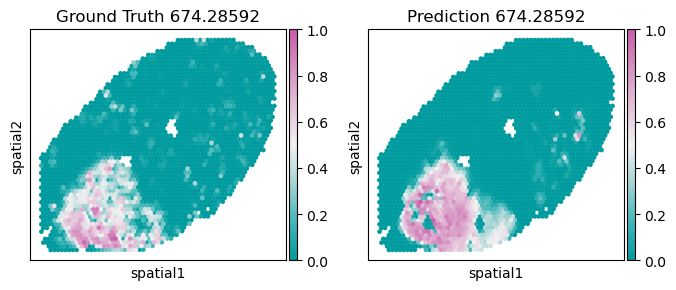

In [11]:
index = 25
name = dataset.target_panel[index]

key_pd, key_gt = 'pd_' + name, 'gt_' + name

temp_array_gt = rna_adata.obs[key_gt].values.copy()
temp_array_pd = rna_adata.obs[key_pd].values.copy()

temp_array_pd = np.exp(temp_array_pd) -1
temp_array_gt =  np.exp(temp_array_gt) -1


# min_value = np.nanmin(temp_array_pd)
# filter out the abnormal spots
target_value = np.nanmean(temp_array_gt) - 8 * np.nanstd(temp_array_gt) 
temp_mask = temp_array_gt < target_value
temp_array_gt[temp_mask] = None

key_norm = 'norm_' + name
rna_adata.obs[key_norm] = (temp_array_gt - np.nanmin(temp_array_gt)) / (np.nanmax(temp_array_gt) - np.nanmin(temp_array_gt))

pd_norm_name = 'pd_norm_' + name
rna_adata.obs[pd_norm_name] = (temp_array_pd - np.nanmin(temp_array_pd)) / (np.nanmax(temp_array_pd) - np.nanmin(temp_array_pd))

################
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.embedding(rna_adata, basis='spatial', color=key_norm, title=f'Ground Truth {name}', ax=axs[0], show=False, cmap=Tropic_7.mpl_colormap) 
sc.pl.embedding(rna_adata, basis='spatial', color=pd_norm_name, title=f'Prediction {name}', ax=axs[1], show=False, cmap=Tropic_7.mpl_colormap) 

### Generate new adata for potential analysis, e.g., multi-omics domain identification

In [12]:
gt_list = defaultdict(list)
pd_list = defaultdict(list)

for index, name in enumerate(rna_adata.obs.columns.tolist()):
    if name[0:2] == 'gt':
        gt_list[name.split('_')[-1]] = rna_adata.obs[name].values
    elif name[0:2] == 'pd':
        pd_list[name.split('_')[-1]] = rna_adata.obs[name].values

gt_dataframe = pd.DataFrame(gt_list)
pd_dataframe = pd.DataFrame(pd_list)

gt_adata = sc.AnnData(gt_dataframe)
pd_adata = sc.AnnData(pd_dataframe)

gt_adata.obsm['spatial'] = rna_adata.obsm['spatial']
pd_adata.obsm['spatial'] = rna_adata.obsm['spatial']

gt_adata.obs.index = rna_adata.obs.index.values
pd_adata.obs.index = rna_adata.obs.index.values